# Exercise 6

Marja Satukangas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers, models


## Exercise 6.1: Convnet encoder-decoder for MNIST (3p)

Change the fully connected autoencoder in tapaaminen6examples into a convnet-based one, ie. use Conv2D and MaxPooling2D layers in encoder and Conv2D and UpSampling2D layers in decoder. Compare the results (visually) to fully connected autoencoder results and write briefly your findings.

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [3]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encdec = keras.Model(input_img, decoder)
encdec.compile(optimizer='adam', loss='binary_crossentropy')
encdec.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)          

In [4]:
hist = encdec.fit(x_train, x_train, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 74s 79ms/step - loss: 0.1756
Epoch 2/5
938/938 [==============================] - 76s 81ms/step - loss: 0.1236
Epoch 3/5
938/938 [==============================] - 77s 82ms/step - loss: 0.1143
Epoch 4/5
938/938 [==============================] - 71s 76ms/step - loss: 0.1092
Epoch 5/5
938/938 [==============================] - 71s 76ms/step - loss: 0.1060


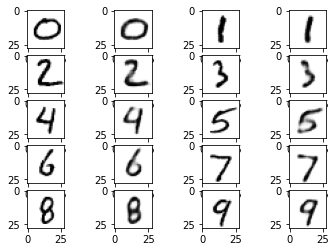

In [5]:
x_test_ed = encdec.predict(x_test)

fig, ax = plt.subplots(5,4)
ax = ax.flatten()

for i in range(10):
    im_idx = np.argwhere(y_test == i)
    pick = np.random.choice(y_test)
    plottable_image = np.reshape(x_test[im_idx][pick], (28, 28))
    another_image = np.reshape(x_test_ed[im_idx][pick], (28, 28))
    ax[i*2].imshow(plottable_image, cmap='gray_r')
    ax[i*2+1].imshow(another_image, cmap='gray_r')


## Findings

Convnet autoencoder gives more precise result when decoded.

## Exercise 6.2: Imbd review sentiment analysis improvement (3p)

Improve the sentiment analyser in session6examples. You might use different RNN layer (like LSTM), stack two layers, try to manage overfitting etc. Check the code examples in Keras documentation for how to handle for example LSTM layer.

In [13]:
from tensorflow.keras.datasets import imdb 

vocabulary_size = 15000
max_seq_len = 150

(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocabulary_size)

In [14]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

index_dict = imdb.get_word_index()
word_dict = dict([(value, key) for (key, value) in index_dict.items()])

# 0 - padding word, 1 - start word, 2 - out of vocabulary word (so do .get(i-3) from the reverse dictionary))
print(" ".join([word_dict.get(i-3, "#") for i in x_train[8]]))

# join the train and val sets and split with 80/20 ratio
data = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

data_train, data_val, targets_train, targets_val = train_test_split(data, targets, test_size=0.2)

(25000,) (25000,) (25000,) (25000,)
# just got out and cannot believe what a brilliant documentary this is rarely do you walk out of a movie theater in such awe and # lately movies have become so over hyped that the thrill of discovering something truly special and unique rarely happens # # did this to me when it first came out and this movie is doing to me now i didn't know a thing about this before going into it and what a surprise if you hear the concept you might get the feeling that this is one of those # movies about an amazing triumph covered with over the top music and trying to have us fully convinced of what a great story it is telling but then not letting us in # this is not that movie the people tell the story this does such a good job of capturing every moment of their involvement while we enter their world and feel every second with them there is so much beyond the climb that makes everything they go through so much more tense touching the void was also a great doc about 

In [15]:
data_train = tf.keras.preprocessing.sequence.pad_sequences(data_train, maxlen=max_seq_len)
data_val = tf.keras.preprocessing.sequence.pad_sequences(data_val, maxlen=max_seq_len)

print(data_val.shape)

(10000, 150)


In [16]:
embedded_dimension = 16

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedded_dimension))
model.add(layers.LSTM(16, dropout=0.3, return_sequences=True))
model.add(layers.LSTM(16, dropout=0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          240000    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 16)          2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 244,241
Trainable params: 244,241
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist = model.fit(data_train, targets_train, epochs=5, batch_size=32, validation_data=(data_val, targets_val))

Epoch 1/5
1250/1250 [==============================] - 85s 68ms/step - loss: 0.3897 - acc: 0.8208 - val_loss: 0.3277 - val_acc: 0.8758
Epoch 2/5
1250/1250 [==============================] - 84s 67ms/step - loss: 0.2719 - acc: 0.8909 - val_loss: 0.3248 - val_acc: 0.8671
Epoch 3/5
1250/1250 [==============================] - 84s 67ms/step - loss: 0.2467 - acc: 0.9024 - val_loss: 0.2708 - val_acc: 0.8885
Epoch 4/5
1250/1250 [==============================] - 86s 69ms/step - loss: 0.2341 - acc: 0.9071 - val_loss: 0.2913 - val_acc: 0.8731
Epoch 5/5
1250/1250 [==============================] - 85s 68ms/step - loss: 0.2264 - acc: 0.9114 - val_loss: 0.2628 - val_acc: 0.8916


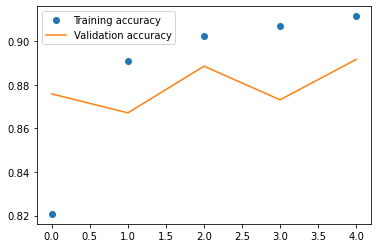

In [18]:
plt.plot(hist.history['acc'], 'o', label='Training accuracy')
plt.plot(hist.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.show()

In [19]:
training=False
print(model.predict(np.array([data_val[6,:]])), targets_val[6])
print(model.predict(np.array([data_val[7,:]])), targets_val[7])
print(model.predict(np.array([data_val[8,:]])), targets_val[8])
print(model.predict(np.array([data_val[9,:]])), targets_val[9])

[[0.08157307]] 0
[[0.00988996]] 0
[[0.9910021]] 1
[[0.9888412]] 1


In [20]:
def classify_review(text, model):
    w2intdict = tf.keras.datasets.imdb.get_word_index()
    seq = tf.keras.preprocessing.sequence.pad_sequences([[w2intdict[w] for w in text]], maxlen=max_seq_len)
    print("score for", text, "is", model.predict(seq))

In [21]:
classify_review(['the', 'movie', 'is', 'utterly', 'disappointing', 'disaster', 'perhaps', 'worst', 'ever'], model)
classify_review(['the', 'movie', 'is', 'extremely', 'nice', 'and', 'entertaining', 'with', 'great', 'casting'], model)
classify_review(['the', 'movie', 'is', 'best', 'possible', 'example', 'of', 'terrible', 'crap'], model)
classify_review(['the', 'latest', 'movie', 'by', 'this', 'abysmal', 'director', 'is', 'terrible', 'crap'], model)

score for ['the', 'movie', 'is', 'utterly', 'disappointing', 'disaster', 'perhaps', 'worst', 'ever'] is [[0.15694743]]
score for ['the', 'movie', 'is', 'extremely', 'nice', 'and', 'entertaining', 'with', 'great', 'casting'] is [[0.5825728]]
score for ['the', 'movie', 'is', 'best', 'possible', 'example', 'of', 'terrible', 'crap'] is [[0.30077064]]
score for ['the', 'latest', 'movie', 'by', 'this', 'abysmal', 'director', 'is', 'terrible', 'crap'] is [[0.5183157]]


## Findings

The model didn't really get better with LSTM. I experimented different embedded dimensions and model depths and widths, activations and optimizers but that didn't help.
